### Explore how good feature selection affect RMSE of log(price)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import category_encoders as ce
import pandas as pd
import subprocess
import pprint as pp
import warnings
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

%matplotlib inline
PATH='../data/'


In [11]:
class RemovingFeatures(TransformerMixin):
    """
    removing feature missing to many values
    """
    def __init__(self, cols_removing):
        self.cols_removing = cols_removing

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.cols_removing, axis=1)


class PoolQCTransformer(TransformerMixin):
    """
    transform PoolQC column
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        map_poolqc = {"PoolQC": {"Ex": 3, "Gd": 2, "Fa": 1, np.nan: 0}}
        return X.replace(map_poolqc)


class PoolAreaTransformer(TransformerMixin):
    """
    replace nan in PoolArea with 0
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        values = {"PoolArea": 0}
        return X.fillna(value=values)


class GrLivAreaTransformer(TransformerMixin):
    """
    perform log transformation of GrLivArea col because it is right-skewed in
    both train and test set
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['GrLivArea'] = np.log1p(X['GrLivArea'])  # log1p(x) more accurate for small x
        return X


class MSSubClassTransformer(TransformerMixin):
    """
    one-hot encoded this feature because it is categorical
    instead of recognize it as an int feature
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        col = 'MSSubClass'
        dummy = pd.get_dummies(X[col], prefix=col)
        drop_col = X.drop(col, axis=1)
        df = pd.concat([dummy, drop_col], axis=1)
        return df


class RemodAfterAdding(TransformerMixin):
    """
    add column RemodAfter = YearRemodAdd - YearBuilt
    YearBuilt and YearRemodAdd has no missing values
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['RemodAfter'] = X['YearRemodAdd'] - X['YearBuilt']
        return X

In [5]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats

def get_train_val(train):
    X = train.iloc[:, 0:-1]
    y = train.iloc[:, -1]  # label SalePrice, last column
    return train_test_split(X, y, test_size=0.3, random_state=42)

def run_baseline_pool(train, test, encoder):
    cols_removing = ['Alley', 'MiscFeature', 'Fence', 'FireplaceQu']
    pipe = Pipeline([
        ('dropping', RemovingFeatures(cols_removing)),
        ('PoolQC', PoolQCTransformer()),
        ('PoolArea', PoolAreaTransformer()),
        ('GrLivArea', GrLivAreaTransformer()),
        # ('AddingColRemodAfter', transformers.RemodAfterAdding()),
        # ('MSSubClass', transformers.MSSubClassTransformer()),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', encoder),
        ('scaler', StandardScaler()),
        ('reg', XGBRegressor(learning_rate=0.15)),
    ])
    kaggle_msg = 'xgb, removing outliers'
    pipe = run_all_steps_baseline(train, test, pipe, kaggle_msg)
    return pipe

def run_all_steps_baseline(train, test, pipe, kaggle_msg):
    # remove outliers
    filter_not_outlier = np.abs(stats.zscore(train['GrLivArea'])) < 2.5
    train = train[filter_not_outlier]

    X_train, X_val, y_train, y_val = get_train_val(train)
   
    pipe.fit(X=X_train, y=y_train)
    val_pred = pipe.predict(X_val)
    mse = mean_squared_error(np.log(y_val), np.log(val_pred))
    rmse = np.sqrt(mse)
    print("validation RMSE:", rmse)
    return pipe

warnings.filterwarnings('ignore')
encoder = ce.OneHotEncoder()
pipe = run_baseline_pool(train, test, encoder)

validation RMSE: 0.11667771861422976


In [24]:
regtuple = pipe.steps[-1]
print(regtuple)
model = regtuple[1]

('reg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.15, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))


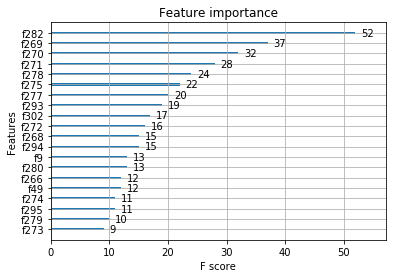

In [29]:
from xgboost import plot_importance

plot_importance(model, max_num_features=20)

In [32]:
cols_removing = ['Alley', 'MiscFeature', 'Fence', 'FireplaceQu']
pipe = Pipeline([
    ('dropping', RemovingFeatures(cols_removing)),
    ('PoolQC', PoolQCTransformer()),
    ('PoolArea', PoolAreaTransformer()),
    ('GrLivArea', GrLivAreaTransformer()),
    # ('AddingColRemodAfter', transformers.RemodAfterAdding()),
    # ('MSSubClass', transformers.MSSubClassTransformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder),
    ('scaler', StandardScaler())
])

X_train, X_val, y_train, y_val = get_train_val(train)
transformed = pipe.fit_transform(X_train)

In [33]:
transformed

array([[ 0.51615776, -0.42282076, -0.20957664, ..., -0.12298707,
        -0.51494368,  0.14029267],
       [-1.93739216,  2.36506837, -0.20957664, ..., -0.12298707,
        -0.51494368, -1.36896114],
       [-1.93739216, -0.42282076,  4.77152406, ..., -0.12298707,
        -0.13741682,  1.64954649],
       ...,
       [ 0.51615776, -0.42282076, -0.20957664, ..., -0.12298707,
        -0.89247054, -1.36896114],
       [ 0.51615776, -0.42282076, -0.20957664, ..., -0.12298707,
        -0.13741682, -0.61433423],
       [ 0.51615776, -0.42282076, -0.20957664, ..., -0.12298707,
        -0.13741682,  0.89491958]])